In [1]:
import json

with open("./params.json", mode = "r", encoding = "utf-8") as f:
    data = json.load(f)
    seed_vals = data["seed_vals"]
    model_path = data["model_path"]
    ensemble_root_path = data["ensemble_root_path"]
    dataset_path_train = data["dataset_path"]["train"]
    dataset_path_test = data["dataset_path"]["test"]
    stats_path = data["stats_path"]
    num_single_sample_timesteps = data["num_single_sample_timesteps"]
    input_window_length = data["input_window_length"]
    label_window_length = data["label_window_length"]
    input_features = data["input_features"]
    label_features = data["label_features"]
    extra_features = data["extra_features"]

    # Usually window_stride = 1 since we want to check each input window
    window_stride = data["window_stride"]
    seed_val = 0

    # Use for kdeplot inference
    batch_size = data["batch_size"]

In [2]:
import torch
import random
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(seed_val)
random.seed(seed_val)
np.random.seed(seed_val)

In [3]:
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import ipywidgets as widgets

from utils.pipeline.Model import TimeSeriesHuggingFaceTransformer
from utils.pipeline.Data import get_mean_std_respected_temporal, WindowedIterableDataset, read_stats
from utils.pipeline.Run import autoregress

In [4]:
# stats = get_mean_std_respected_temporal(
#     dataset_path = dataset_path_train,
#     cols = input_features
# )

# input_stats = get_mean_std_respected_temporal(
#     dataset_path = dataset_path_train,
#     cols = input_features,
#     num_single_sample_timesteps = num_single_sample_timesteps,
#     input_window_len = input_window_length,
#     label_window_len = label_window_length,
#     window_stride = window_stride
# )

# if(set(input_features) == set(label_features)):
#     output_stats = input_stats
# else:
#     output_stats = get_mean_std_respected_temporal(
#         dataset_path = dataset_path_train,
#         cols = label_features,
#         num_single_sample_timesteps = num_single_sample_timesteps,
#         input_window_len = input_window_length,
#         label_window_len = label_window_length,
#         window_stride = window_stride
#     )

stats = read_stats(path = stats_path)

df_test = WindowedIterableDataset(
    dataset_path = dataset_path_test,
    input_stats = stats,
    label_stats = stats,
    input_features = input_features,
    label_features = label_features,
    extra_features = extra_features,
    num_single_sample_timesteps = num_single_sample_timesteps,
    stride = window_stride,
    input_window_length = input_window_length,
    label_window_length = label_window_length,
    inference = True
)

data_loader_test = DataLoader(
    df_test,
    batch_size = 1,    # One windowed datapoint at a time
    pin_memory = True
)

## Prediction

In [5]:
model_paths = [f"{ensemble_root_path}/8/T5-{input_window_length}-{label_window_length}-{window_stride}-{val}.pt" for val in seed_vals]

In [6]:
test_loss = 0.0
test_progress_bar = tqdm(
    data_loader_test
)

num_label_features = len(label_features)

num_datapoints_per_timeseries = 1 + (num_single_sample_timesteps - (input_window_length + label_window_length) + 1) // window_stride

num_visible_timesteps = 1000

def analysis(target_timeseries_idx, feature, figure_range, selected_window_idx, scroll_start):
    with torch.no_grad():
        for datapoint_idx, (batch_x, batch_y, x_labels, extra_full) in enumerate(test_progress_bar):
            if(datapoint_idx == (target_timeseries_idx + 1) * num_datapoints_per_timeseries):
                break
            
            if(datapoint_idx >= target_timeseries_idx * num_datapoints_per_timeseries and datapoint_idx < (target_timeseries_idx + 1) * num_datapoints_per_timeseries):
                window_idx = datapoint_idx % num_datapoints_per_timeseries

                if(selected_window_idx is not None and selected_window_idx != window_idx):
                    continue

                batch_x = batch_x.to(device)
                batch_y = batch_y.to(device)

                x = list(range(num_single_sample_timesteps))

                feature_idx = label_features.index(feature)
                feature_label = batch_y[0, :, feature_idx].cpu()

                all_preds = torch.zeros((len(model_paths),) + batch_y.shape)
                all_attns = torch.zeros((len(model_paths),) + (label_window_length, input_window_length))

                for i, path in enumerate(model_paths):
                    criterion = torch.nn.MSELoss()
                    model = torch.load(path, weights_only = False).to(device)
                    model.eval()

                    preds = autoregress(
                        model = model,
                        batch_x = batch_x,
                        batch_y = batch_y,
                        device = device,
                        extract_attention = True
                    )

                    loss = criterion(preds, batch_y)
                    test_progress_bar.set_postfix({
                        "single_test_loss": f"{loss.item():.6f}"
                    })

                    all_preds[i, :, :, :] = preds

                    all_attns[i, :, :] = model.get_average_attention_values()

                    del model
                    torch.cuda.empty_cache()


                feature_pred = all_preds[:, 0, :, feature_idx].cpu()
                feature_x_labels = x_labels[0, :, feature_idx]
                extra_values = extra_full[0, :, 0] / 50
            
                # feature_label = (feature_label * output_stats[window_idx, f"{feature}_std"]) + output_stats[window_idx, f"{feature}_mean"]
                # feature_pred = (feature_pred * output_stats[window_idx, f"{feature}_std"]) + output_stats[window_idx, f"{feature}_mean"]
                # No normalization on x_labels in WindowedIterableDataset!

                feature_label = (feature_label * stats[0, f"{feature}_std"]) + stats[0, f"{feature}_mean"]
                feature_pred = (feature_pred * stats[0, f"{feature}_std"]) + stats[0, f"{feature}_mean"]

                mean_feature_preds = feature_pred.mean(dim = 0)
                std_feature_preds = feature_pred.std(dim = 0)

                # print(feature_pred[0, -1])
                # print(feature_pred[1, -1])
                # print(feature_pred[2, -1])
                # print(feature_pred[3, -1])
                # print(feature_pred[4, -1])


                sns.set_theme(style = "whitegrid")
                fig, ax = plt.subplots(figsize = (16, 8))
                ax.set_ylim(-figure_range, figure_range)

                # Input region
                ax.axvspan(
                    x[window_idx * window_stride],
                    x[window_idx * window_stride + input_window_length - 1],
                    color = "green",
                    alpha = 0.3,
                    label = "Input Sequence Region"
                )

                # Label values
                sns.scatterplot(
                    x = x,
                    y = feature_x_labels,
                    marker = "o",
                    label = f"{feature}_label (circles)",
                    color = "blue",
                    ax = ax
                )

                # Extra values
                sns.lineplot(
                    x = x,
                    y = extra_values,
                    label = f"{extra_features[0]}",
                    color = "orange",
                    alpha = 0.5,
                    ax = ax
                )
                plt.fill_between(
                    x = x,
                    y1 = extra_values,
                    color = "orange",
                    alpha = 0.3
                )

                # Pred values
                sns.scatterplot(
                    x = x[(input_window_length + window_idx * window_stride):(input_window_length + window_idx * window_stride + label_window_length)],
                    y = mean_feature_preds,
                    marker = "x",
                    label = f"{feature}_pred (crosses)",
                    color = "red",
                    ax = ax
                )
                ax.fill_between(
                    x = x[(input_window_length + window_idx * window_stride):(input_window_length + window_idx * window_stride + label_window_length)],
                    y1 = mean_feature_preds - 2 * std_feature_preds,
                    y2 = mean_feature_preds + 2 * std_feature_preds,
                    color = "gray",
                    alpha = 0.5,
                    label = f"{feature} ± 2 std"
                )

                # sns.scatterplot(
                #     x = x[(input_window_length + window_idx * window_stride):(input_window_length + window_idx * window_stride + label_window_length)],
                #     y = feature_pred_mean,
                #     marker = "x",
                #     label = f"{feature}_pred (crosses)",
                #     color = "red",
                #     ax = ax
                # )
                # ax.fill_between(
                #     x = x[(input_window_length + window_idx * window_stride):(input_window_length + window_idx * window_stride + label_window_length)],
                #     y1 = feature_pred_mean - 2 * feature_pred_std,
                #     y2 = feature_pred_mean + 2 * feature_pred_std,
                #     color = "gray",
                #     alpha = 0.5,
                #     label = f"{feature} ± 2 std"
                # )

                ax.set_xlim(scroll_start, scroll_start + num_visible_timesteps)
                ax.set_title(f"{feature} Value Ground-Truth vs. Prediction")
                ax.set_xlabel("Timesteps")
                ax.set_ylabel(feature)
                ax.legend()

                plt.tight_layout()
                display(fig)
                plt.close(fig)
                
                # # avg_attn_vals = model.get_average_attention_values()
                avg_attn_vals = all_attns.mean(dim = 0).numpy()
                del all_attns

                for i in range(20):                                      # First 20 predictions following input sequence 
                    output_row = avg_attn_vals[i, :]
                    top_k_indices = np.argsort(output_row)[::-1][:10]    # Top 10 highest attention input timesteps
                    top_k_scores = output_row[top_k_indices]
                    print(f"Output Timestep {input_window_length + window_idx * window_stride + i + 1}")
                    print(f"    Input Timesteps {top_k_indices + (window_idx * window_stride + 1)}")
                    print(f"    Scores {[f'{score:.5f}' for score in top_k_scores]}\n")


0it [00:00, ?it/s]

In [ ]:
widgets.interact(
    analysis,
    target_timeseries_idx = widgets.IntSlider(
        value = 0,
        min = 0,
        max = 1000,
        step = 1,
        description = "Timeseries Index",
        layout = widgets.Layout(width = "500px"),
        style = {"description_width": "100px"}
    ),
    feature = widgets.Dropdown(
        options = label_features,
        value = "u_list",
        description = "Feature",
        style = {"description_width": "100px"}
    ),
    figure_range = widgets.FloatSlider(
        value = 1,
        min = 0.1,
        max = 50,
        step = 0.1,
        description = "Figure range",
        style = {"description_width": "100px"}
    ),
    selected_window_idx = widgets.IntSlider(
        value = 0,
        min = 0,
        max = num_datapoints_per_timeseries - 1,
        step = 1,
        description = "Window Index",
        layout = widgets.Layout(width = "400px"),
        style = {"description_width": "100px"}
    ),
    scroll_start = widgets.IntSlider(
        value = 0,
        min = 0,
        max = num_single_sample_timesteps - num_visible_timesteps,
        step = 200,
        description = "Scroll X",
        layout = widgets.Layout(width = "1000px"),
        style = {"description_width": "100px"}
    )
);

interactive(children=(IntSlider(value=0, description='Timeseries Index', layout=Layout(width='500px'), max=100…

In [ ]:
df_test = WindowedIterableDataset(
    dataset_path = dataset_path_test,
    input_stats = input_stats,
    label_stats = output_stats,
    input_features = input_features,
    label_features = label_features,
    extra_features = extra_features,
    num_single_sample_timesteps = num_single_sample_timesteps,
    stride = window_stride,
    input_window_length = input_window_length,
    label_window_length = label_window_length,
    inference = True
)

data_loader_test = DataLoader(
    df_test,
    batch_size = batch_size,
    pin_memory = True
)

test_loss = 0.0
test_progress_bar = tqdm(
    data_loader_test
)

num_label_features = len(label_features)

num_datapoints_per_timeseries = 1 + (num_single_sample_timesteps - (input_window_length + label_window_length) + 1) // window_stride

first_timestep_stds = []
first_timestep_extras = []
feature = "u_list"

with torch.no_grad():
    for datapoint_idx, (batch_x, batch_y, x_labels, extra_full) in enumerate(test_progress_bar):
        window_idx = datapoint_idx % num_datapoints_per_timeseries

        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        x = list(range(num_single_sample_timesteps))

        feature_idx = label_features.index(feature)
        feature_label = batch_y[:, :, feature_idx].cpu()

        all_preds = torch.zeros((len(model_paths),) + batch_y.shape)

        for i, path in enumerate(model_paths):
            criterion = torch.nn.MSELoss()
            model = torch.load(path, weights_only = False).to(device)
            model.eval()

            preds = autoregress(
                model = model,
                batch_x = batch_x,
                batch_y = batch_y,
                device = device,
                extract_attention = True
            )

            loss = criterion(preds, batch_y)
            test_progress_bar.set_postfix({
                "single_test_loss": f"{loss.item():.6f}"
            })

            all_preds[i, :, :, :] = preds

            del model
            torch.cuda.empty_cache()


        feature_pred = all_preds[:, :, :, feature_idx].cpu()
        feature_x_labels = x_labels[:, :, feature_idx]
        extra_values = extra_full[:, :, 0] / 50
    
        feature_label = (feature_label * output_stats[window_idx, f"{feature}_std"]) + output_stats[window_idx, f"{feature}_mean"]
        feature_pred = (feature_pred * output_stats[window_idx, f"{feature}_std"]) + output_stats[window_idx, f"{feature}_mean"]

        mean_feature_preds = feature_pred.mean(dim = 0)
        std_feature_preds = feature_pred.std(dim = 0)

        first_timestep_stds.extend(std_feature_preds[:, 0].tolist())
        first_timestep_extras.extend(extra_values[:, input_window_length + window_idx * window_stride].tolist())


1291it [50:17,  2.34s/it, single_test_loss=0.670237]


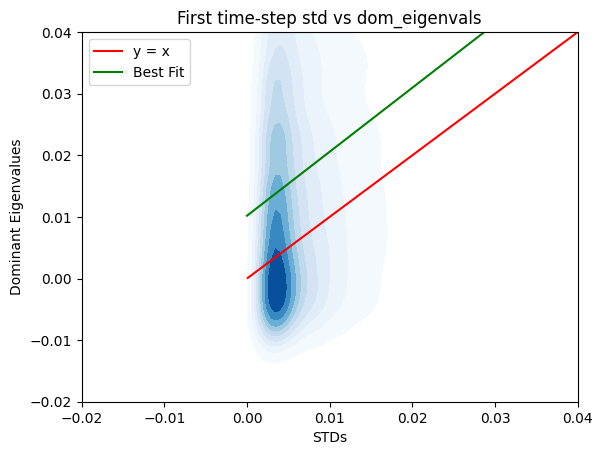

In [14]:
sns.kdeplot(
    x = first_timestep_stds,
    y = first_timestep_extras,
    fill = True,
    cmap = "Blues"
)

plt.plot(
    [min(first_timestep_stds), max(first_timestep_stds)],
    [min(first_timestep_stds), max(first_timestep_stds)],
    color = "red",
    linestyle = "-",
    label = "y = x"
)

# sns.regplot(x = first_timestep_stds, y = first_timestep_extras, scatter = False, line_kws = {"color": "green"}, ci = None)

slope, intercept = np.polyfit(first_timestep_stds, first_timestep_extras, 1)

# Generate points for the fit line
x_fit = np.linspace(0, 0.04, 100)
y_fit = slope * x_fit + intercept

plt.plot(
    x_fit,
    y_fit,
    color = "green",
    label = "Best Fit"    
)

plt.xlim(-0.02, 0.04)
plt.ylim(-0.02, 0.04)

plt.xlabel("STDs")
plt.ylabel("Dominant Eigenvalues")
plt.legend()
plt.title("First time-step std vs dom_eigenvals")

plt.show()